# Phenotype Clustering

In [120]:
import glob
import itertools as it 
import os
import random
import sys
from textwrap import wrap

from adjustText import adjust_text
import dynamicTreeCut
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import rpy2.robjects as robjects
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
import seaborn as sns
sns.set(rc={'font.sans-serif':'Helvetica'})
sns.set(style='whitegrid', rc={'font.sans-serif':'Helvetica'})

from IPython.display import display, HTML

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
traits = pd.read_table('../../h2-estimation/data/traits.tsv', index_col=0)

In [83]:
corrs = pd.read_table('../../h2-estimation/private_output/ukb_stan/combined/vtu_opt_100_0.5.tsv.gz',
                      index_col=0)
corrs = corrs[(corrs['p1_category'].isnull() == False) & 
              (corrs['p2_category'].isnull() == False)]
corrs = corrs[(corrs['p1_category'].isin(['INI', 'HC'])) & 
              (corrs['p2_category'].isin(['INI', 'HC']))]
corrs_p = corrs.pivot(index='p1_code', columns='p2_code', values='omegacor21')
for pheno in set(corrs_p.index) - set(corrs_p.columns):
    corrs_p[pheno] = np.nan
corrs_p = corrs_p.T
for pheno in set(corrs_p.index) - set(corrs_p.columns):
    corrs_p[pheno] = np.nan
corrs_p = corrs_p.T
corrs_p = corrs_p.loc[corrs_p.columns]
for p in corrs_p.index:
    corrs_p.loc[p, p] = 1
corrs_p = pd.DataFrame(np.triu(corrs_p) + np.triu(corrs_p,1).T, 
                       index=corrs_p.index, columns=corrs_p.columns)
corrs_p = corrs_p.replace(np.nan, 0)

In [331]:
ps = ['INI30150', 'INI3062', 'INI3063', 'HC382']
ps += ['HC276', 'INI5263', 'INI5265']
# ind = list(set([x for x in corrs_p.index if 'INI' in x][0:100]) | set(ps))
ind = list(set(random.sample(corrs_p.index, 100)) | set(ps))
tdf = corrs_p.loc[ind, ind]
# tdf = corrs_p.iloc[0:300, 0:300]
distances = pdist(tdf, "euclidean")
link = linkage(distances, "complete")
clusters = dynamicTreeCut.cutreeHybrid(link, distances, deepSplit=4, minClusterSize=4)

('..cutHeight not given, setting it to', 11.577105982379679, ' ===>  99% of the (truncated) height range in dendro.')
..done.


In [338]:
cdf = pd.DataFrame({'code':tdf.index, 'cluster':clusters['labels']})
cdf['ps'] = cdf['code'].isin(ps)
asthma_cluster = cdf.loc[cdf['code'] == 'HC382', 'cluster'].values[0]
glaucoma_cluster = cdf.loc[cdf['code'] == 'HC276', 'cluster'].values[0]
asthma_cluster_ps = list(cdf.loc[cdf['cluster'] == asthma_cluster, 'code'])
glaucoma_cluster_ps = list(cdf.loc[cdf['cluster'] == glaucoma_cluster, 'code'])

In [346]:
traits.loc[asthma_cluster_ps]

,regtype,category,numcases,phenotype
code,,,,
INI1003039,linear,INI,438063.0,Number_days_moderate_physical_activity
HC440,logistic,HC,12186.0,atrial_flutter
INI1588,linear,INI,243166.0,Average_weekly_beer_plus_cider_intake
INI1003038,linear,INI,438063.0,Number_days_walked_more_than_10_minutes
INI1488,linear,INI,337201.0,Tea_intake
INI25584,linear,INI,6302.0,Weighted-mean_L1_in_tract_inferior_longitudina...
HC382,logistic,HC,43626.0,asthma
HC91,logistic,HC,954.0,psoriatic_arthropathy
INI25643,linear,INI,6302.0,Weighted-mean_L3_in_tract_posterior_thalamic_r...


In [347]:
traits.loc[glaucoma_cluster_ps]

,regtype,category,numcases,phenotype
code,,,,
INI30160,linear,INI,327479.0,Basophill_count
HC161,logistic,HC,984.0,prostatitis
INI5265,linear,INI,81412.0,Corneal_resistance_factor_(left)
HC146,logistic,HC,4391.0,pleural_effusion
HC276,logistic,HC,5863.0,glaucoma
INI25822,linear,INI,7058.0,Volume_of_grey_matter_in_Angular_Gyrus_(left)
INI5256,linear,INI,81534.0,Corneal_hysteresis_(right)
INI5263,linear,INI,81412.0,"Intra-ocular_pressure,_Goldmann-correlated_(left)"
INI25860,linear,INI,7058.0,Volume_of_grey_matter_in_Occipital_Fusiform_Gy...


In [348]:
corrs_p.loc[ps, ps]

p2_code,INI30150,INI3062,INI3063,HC382,HC276,INI5263,INI5265
p2_code,,,,,,,
INI30150,1.000000,-0.064631,0.003346,0.240994,0.036112,0.074664,-0.110337
INI3062,-0.064631,1.000000,0.935537,-0.231214,-0.026343,-0.999561,-0.243014
INI3063,0.003346,0.935537,1.000000,-0.387284,-0.005179,-0.999743,-0.229794
HC382,0.240994,-0.231214,-0.387284,1.000000,-0.062627,-0.053234,0.084706
HC276,0.036112,-0.026343,-0.005179,-0.062627,1.000000,0.658688,0.268248
INI5263,0.074664,-0.999561,-0.999743,-0.053234,0.658688,1.000000,0.804167
INI5265,-0.110337,-0.243014,-0.229794,0.084706,0.268248,0.804167,1.000000


In [352]:
s = 'CANINE BREED-SPECIFIC RISKS OF FREQUENTLY DIAGNOSED DISEASES AT VETERINARY TEACHING HOSPITALS'
s = [x.lower() for x in s.split()]
' '.join([x[0].upper() + x[1:].lower() for x in s])

'Canine Breed-specific Risks Of Frequently Diagnosed Diseases At Veterinary Teaching Hospitals'

['canine',
 'breed-specific',
 'risks',
 'of',
 'frequently',
 'diagnosed',
 'diseases',
 'at',
 'veterinary',
 'teaching',
 'hospitals']

In [334]:
colors = pd.Series(sns.color_palette("cubehelix", len(set(clusters['labels']))))
colors.index = list(set(clusters['labels']))
ps_colors = pd.Series([(0.5, 0.5, 0.5), (1, 1, 1)], index=[0, 1])

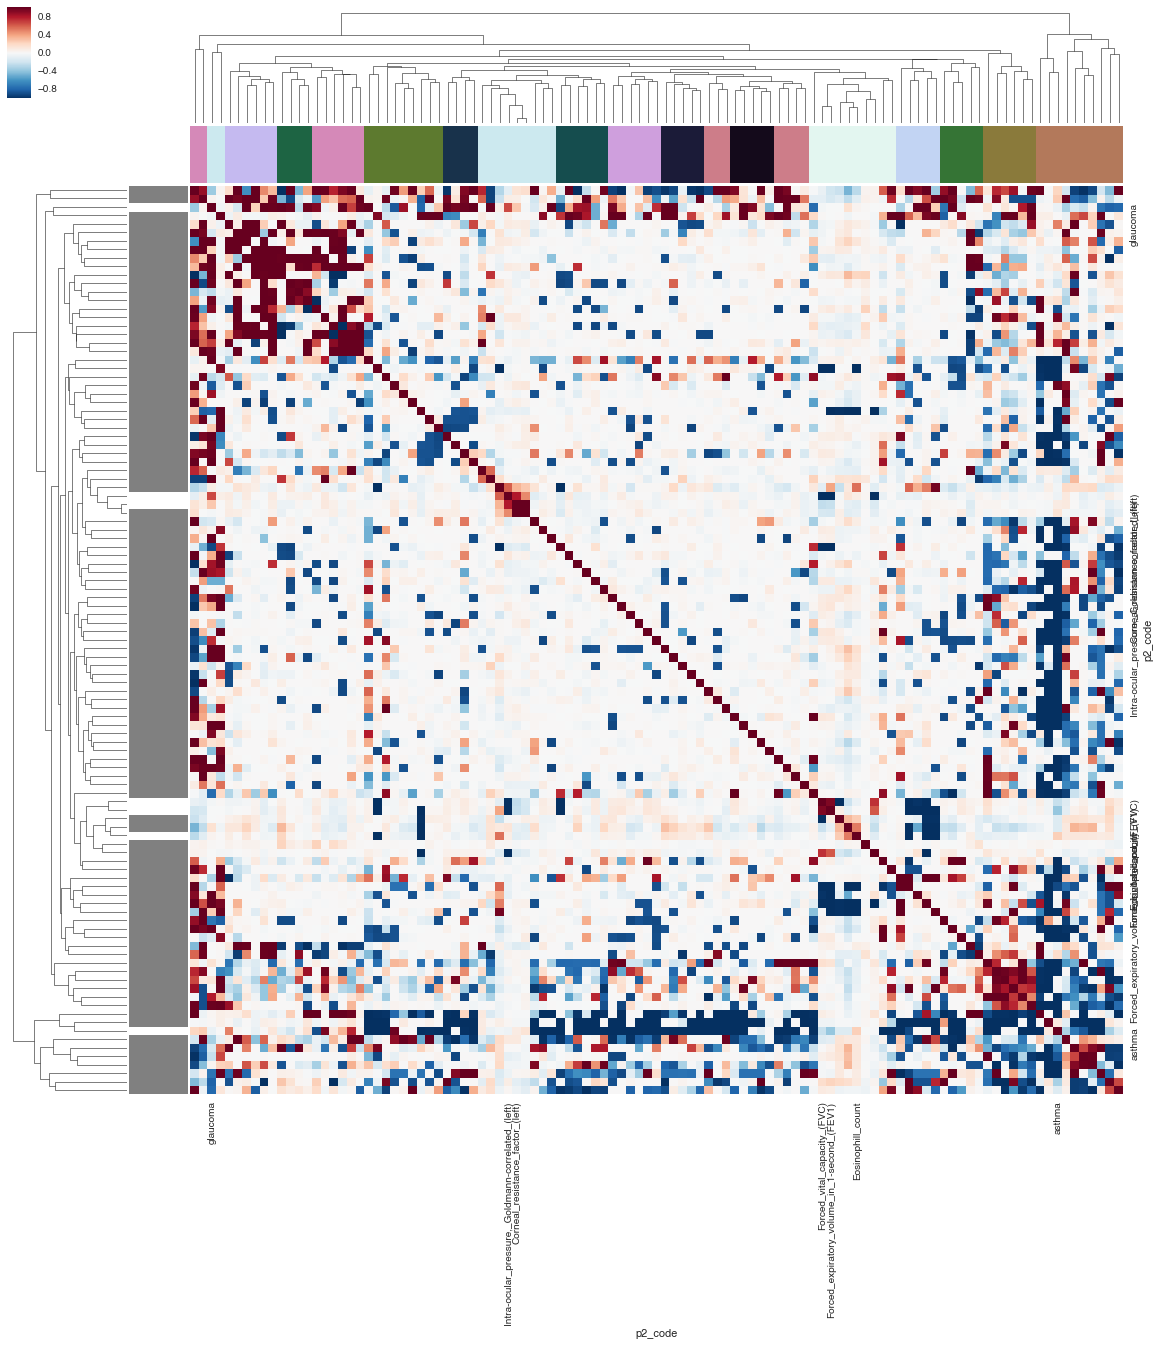

In [336]:
xtl = pd.Series('', index=tdf.index)
xtl.loc[ps] = traits.loc[ps, 'phenotype']
# sns.clustermap(tdf, col_colors=colors[cdf.cluster].values,
#                row_colors=colors[cdf.cluster].values)
sns.clustermap(
    tdf,
    figsize=(20, 20),
    method='complete',
    row_colors=list(ps_colors[cdf['ps'].astype(int)].values),
    col_colors=list(colors[cdf.cluster].values),
    xticklabels=xtl,
    yticklabels=xtl,
)

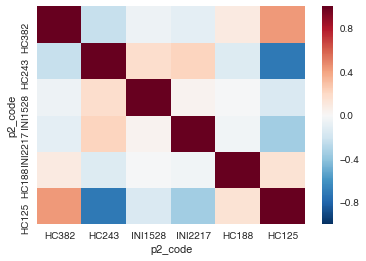

In [273]:
sns.heatmap(corrs_p.loc[cluster_ps, cluster_ps])

In [305]:
adj = corrs_p.abs() ** 9
np.fill_diagonal(adj.values, 0)
cty = adj.sum() / adj.sum().max()
print((adj.loc['HC382'] > 0.95).sum())
print(adj.loc['HC382', ps])

564
p2_code
INI30150    0.000003
INI3062     0.000002
INI3063     0.000196
HC382       0.000000
Name: HC382, dtype: float64


In [ ]:
distances = pdist(tdf, "euclidean")
link = linkage(distances, "average")
clusters = dynamicTreeCut.cutreeHybrid(link, distances, deepSplit=4, minClusterSize=4)

In [ ]:
ps = ['INI30150', 'INI3062', 'INI3063', 'HC382']

In [86]:
for p in ['INI30150', 'INI3062', 'INI3063']:
    print(traits.loc[p, 'phenotype'], corrs.loc['HC382_{}'.format(p), 'omegacor21'])

('Eosinophill_count', 0.24099379678000002)
('Forced_vital_capacity_(FVC)', -0.23121362717900001)
('Forced_expiratory_volume_in_1-second_(FEV1)', -0.38728404475999995)


In [81]:
corrs[(corrs['p1_code'] == 'HC382') | (corrs['p2_code'] == 'HC382')].sort_values(
    by='omegacor21', ascending=False)[['p1', 'p2', 'omegacor21']].head(10)

,p1,p2,omegacor21
1022409,asthma,Number_of_children_fathered,0.980156
174927,asthma,trigemminal_neuralgia,0.975611
174937,asthma,spinal_stenosis,0.951373
955648,asthma,Mean_ISOVF_in_posterior_thalamic_radiation_on_...,0.950734
175385,asthma,Nucleated_red_blood_cell_percentage,0.939953
174925,asthma,urticaria,0.936796
174993,asthma,back_pain,0.925102
585402,asthma,Wheeze_or_whistling_in_the_chest_in_last_year,0.916498
174999,asthma,appendicitis,0.887209
174930,asthma,fracture_shoulder_/_scapula,0.878831


In [73]:
ind = [x for x in corrs_p.index if 'INI' in x] + ['HC382']
tdf = corrs_p.loc[ind, ind]
c = corrs_p.corr()

In [74]:
se = c.loc['HC382'].drop('HC382')
se = se.sort_values(ascending=False)

In [75]:
traits[traits.phenotype.apply(lambda x: 'Eosino' in str(x))]

,regtype,category,numcases,phenotype
code,,,,
INI30150,linear,INI,327479.0,Eosinophill_count
INI30210,linear,INI,327482.0,Eosinophill_percentage


In [76]:
traits.loc[se.head(20).index]

,regtype,category,numcases,phenotype
p2_code,,,,
INI1003043,linear,INI,436473.0,Usual_walking_pace
INI102,linear,INI,318344.0,"Pulse_rate,_automated_reading"
INI137,linear,INI,337163.0,Number_of_treatments/medications_taken
HC221,logistic,HC,20440.0,diabetes
INI20153,linear,INI,110424.0,"Forced_expiratory_volume_in_1-second_(FEV1),_p..."
INI1498,linear,INI,337201.0,Coffee_intake
INI20015,linear,INI,336513.0,Sitting_height
INI135,linear,INI,337163.0,Number_of_self-reported_non-cancer_illnesses
INI21002,linear,INI,336260.0,Weight


/home/groups/mrivas/software/anaconda2_sherlock2/envs/h2-estimation/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


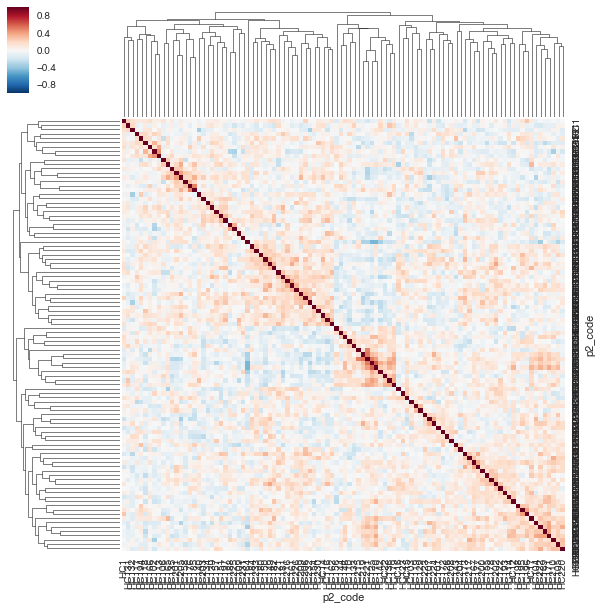

In [40]:
sns.clustermap(c)